# DreamBooth Style Transfer Test - Kaggle

Test style transfer từ ảnh COCO với 2 style đã train: New_Realism và Contemporary_Realism


## Setup


In [1]:
import os
import torch

if not torch.cuda.is_available():
    print("WARNING: No GPU detected!")
else:
    print(f"GPU: {torch.cuda.get_device_name(0)}")


GPU: Tesla P100-PCIE-16GB


In [2]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline
import torch

os.environ["XFORMERS_DISABLED"] = "1"

try:
    import xformers
    USE_XFORMERS = True
except:
    USE_XFORMERS = False

STYLES = ["New_Realism", "Contemporary_Realism"]
UNIQUE_TOKEN = "sks"
MIXED_PRECISION = "fp16"
STRENGTH = 0.75

STYLE_CHECKPOINT_MAP = {
    "New_Realism": "/kaggle/input/real1k/dreambooth_checkpoints",
    "Contemporary_Realism": "/kaggle/input/priorimages/dreambooth_checkpoints",
}

COCO_IMAGE_PATHS = [
    "/kaggle/input/coco-2017-dataset/coco2017/val2017",
]

for style_name, checkpoint_base in STYLE_CHECKPOINT_MAP.items():
    if os.path.exists(checkpoint_base):
        print(f"{style_name}: {checkpoint_base}")
    else:
        print(f"{style_name}: {checkpoint_base} (not found)")

OUTPUT_DIR = Path("/kaggle/working/inference_samples")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print(f"Output: {OUTPUT_DIR}")


2025-11-17 00:00:36.364923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763337636.563379      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763337636.617023      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

New_Realism: /kaggle/input/real1k/dreambooth_checkpoints
Contemporary_Realism: /kaggle/input/priorimages/dreambooth_checkpoints
Output: /kaggle/working/inference_samples


In [3]:
coco_image_dir = None
for path in COCO_IMAGE_PATHS:
    if os.path.exists(path):
        coco_image_dir = Path(path)
        print(f"Found COCO images: {coco_image_dir}")
        break

if coco_image_dir is None:
    print("COCO dataset not found")
    coco_image_dir = Path("/kaggle/input/coco2017/val2017")

image_files = list(coco_image_dir.glob("*.jpg"))[:5]
if len(image_files) == 0:
    image_files = list(coco_image_dir.glob("*.png"))[:5]

print(f"Found {len(image_files)} images")
for img_path in image_files:
    print(f"  {img_path.name}")

coco_images = []
for img_path in image_files:
    img = Image.open(img_path).convert("RGB")
    img = img.resize((512, 512))
    coco_images.append(img)
    print(f"Loaded: {img_path.name} ({img.size})")


Found COCO images: /kaggle/input/coco-2017-dataset/coco2017/val2017
Found 5 images
  000000011197.jpg
  000000219485.jpg
  000000151000.jpg
  000000371677.jpg
  000000038825.jpg
Loaded: 000000011197.jpg ((512, 512))
Loaded: 000000219485.jpg ((512, 512))
Loaded: 000000151000.jpg ((512, 512))
Loaded: 000000371677.jpg ((512, 512))
Loaded: 000000038825.jpg ((512, 512))


In [4]:
print("Loading baseline model...")
baseline_pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16 if MIXED_PRECISION == "fp16" else torch.float32,
    safety_checker=None,
    requires_safety_checker=False,
)
if torch.cuda.is_available():
    baseline_pipeline = baseline_pipeline.to("cuda")
    if not USE_XFORMERS:
        baseline_pipeline.enable_attention_slicing()
print("Baseline model loaded")


Loading baseline model...


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Baseline model loaded


In [5]:
print("Loading style models...")
style_pipelines = {}

for style_name in STYLES:
    if style_name not in STYLE_CHECKPOINT_MAP:
        print(f"No checkpoint path mapped for {style_name}")
        continue
    
    checkpoint_base = Path(STYLE_CHECKPOINT_MAP[style_name])
    checkpoint_path = checkpoint_base / style_name
    
    if not checkpoint_base.exists():
        print(f"Dataset not found: {checkpoint_base}")
        continue
    
    if not checkpoint_path.exists():
        print(f"Checkpoint not found: {checkpoint_path}")
        if checkpoint_base.exists():
            print(f"Available in {checkpoint_base}: {[d.name for d in checkpoint_base.iterdir() if d.is_dir()]}")
        continue
    
    print(f"\nLoading {style_name} from {checkpoint_base}...")
    try:
        pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
            str(checkpoint_path),
            torch_dtype=torch.float16 if MIXED_PRECISION == "fp16" else torch.float32,
            safety_checker=None,
            requires_safety_checker=False,
        )
        if torch.cuda.is_available():
            pipeline = pipeline.to("cuda")
            if not USE_XFORMERS:
                pipeline.enable_attention_slicing()
        style_pipelines[style_name] = pipeline
        print(f"{style_name} loaded successfully")
    except Exception as e:
        print(f"Error loading {style_name}: {e}")


Loading style models...

Loading New_Realism from /kaggle/input/real1k/dreambooth_checkpoints...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

New_Realism loaded successfully

Loading Contemporary_Realism from /kaggle/input/priorimages/dreambooth_checkpoints...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Contemporary_Realism loaded successfully


In [6]:
print("\nPerforming style transfer...")
prompt = f"a {UNIQUE_TOKEN} style painting"
baseline_prompt = "a painting"

baseline_results = []
for i, coco_img in enumerate(coco_images):
    print(f"\nProcessing image {i+1}/{len(coco_images)}...")
    result = baseline_pipeline(
        prompt=baseline_prompt,
        image=coco_img,
        strength=STRENGTH,
        num_inference_steps=50,
        guidance_scale=7.5,
    ).images[0]
    baseline_results.append(result)
    result.save(OUTPUT_DIR / f"baseline_transfer_{i+1}.png")
print(f"Saved {len(baseline_results)} baseline transfers")



Performing style transfer...

Processing image 1/5...


  0%|          | 0/37 [00:00<?, ?it/s]


Processing image 2/5...


  0%|          | 0/37 [00:00<?, ?it/s]


Processing image 3/5...


  0%|          | 0/37 [00:00<?, ?it/s]


Processing image 4/5...


  0%|          | 0/37 [00:00<?, ?it/s]


Processing image 5/5...


  0%|          | 0/37 [00:00<?, ?it/s]

Saved 5 baseline transfers


In [7]:
all_results = {}

for style_name, pipeline in style_pipelines.items():
    print(f"\nTransferring {style_name}...")
    style_results = []
    for i, coco_img in enumerate(coco_images):
        print(f"  Image {i+1}/{len(coco_images)}")
        result = pipeline(
            prompt=prompt,
            image=coco_img,
            strength=STRENGTH,
            num_inference_steps=50,
            guidance_scale=7.5,
        ).images[0]
        style_results.append(result)
        result.save(OUTPUT_DIR / f"{style_name}_transfer_{i+1}.png")
    all_results[style_name] = style_results
    print(f"Saved {len(style_results)} transfers")



Transferring New_Realism...
  Image 1/5


  0%|          | 0/37 [00:00<?, ?it/s]

  Image 2/5


  0%|          | 0/37 [00:00<?, ?it/s]

  Image 3/5


  0%|          | 0/37 [00:00<?, ?it/s]

  Image 4/5


  0%|          | 0/37 [00:00<?, ?it/s]

  Image 5/5


  0%|          | 0/37 [00:00<?, ?it/s]

Saved 5 transfers

Transferring Contemporary_Realism...
  Image 1/5


  0%|          | 0/37 [00:00<?, ?it/s]

  Image 2/5


  0%|          | 0/37 [00:00<?, ?it/s]

  Image 3/5


  0%|          | 0/37 [00:00<?, ?it/s]

  Image 4/5


  0%|          | 0/37 [00:00<?, ?it/s]

  Image 5/5


  0%|          | 0/37 [00:00<?, ?it/s]

Saved 5 transfers


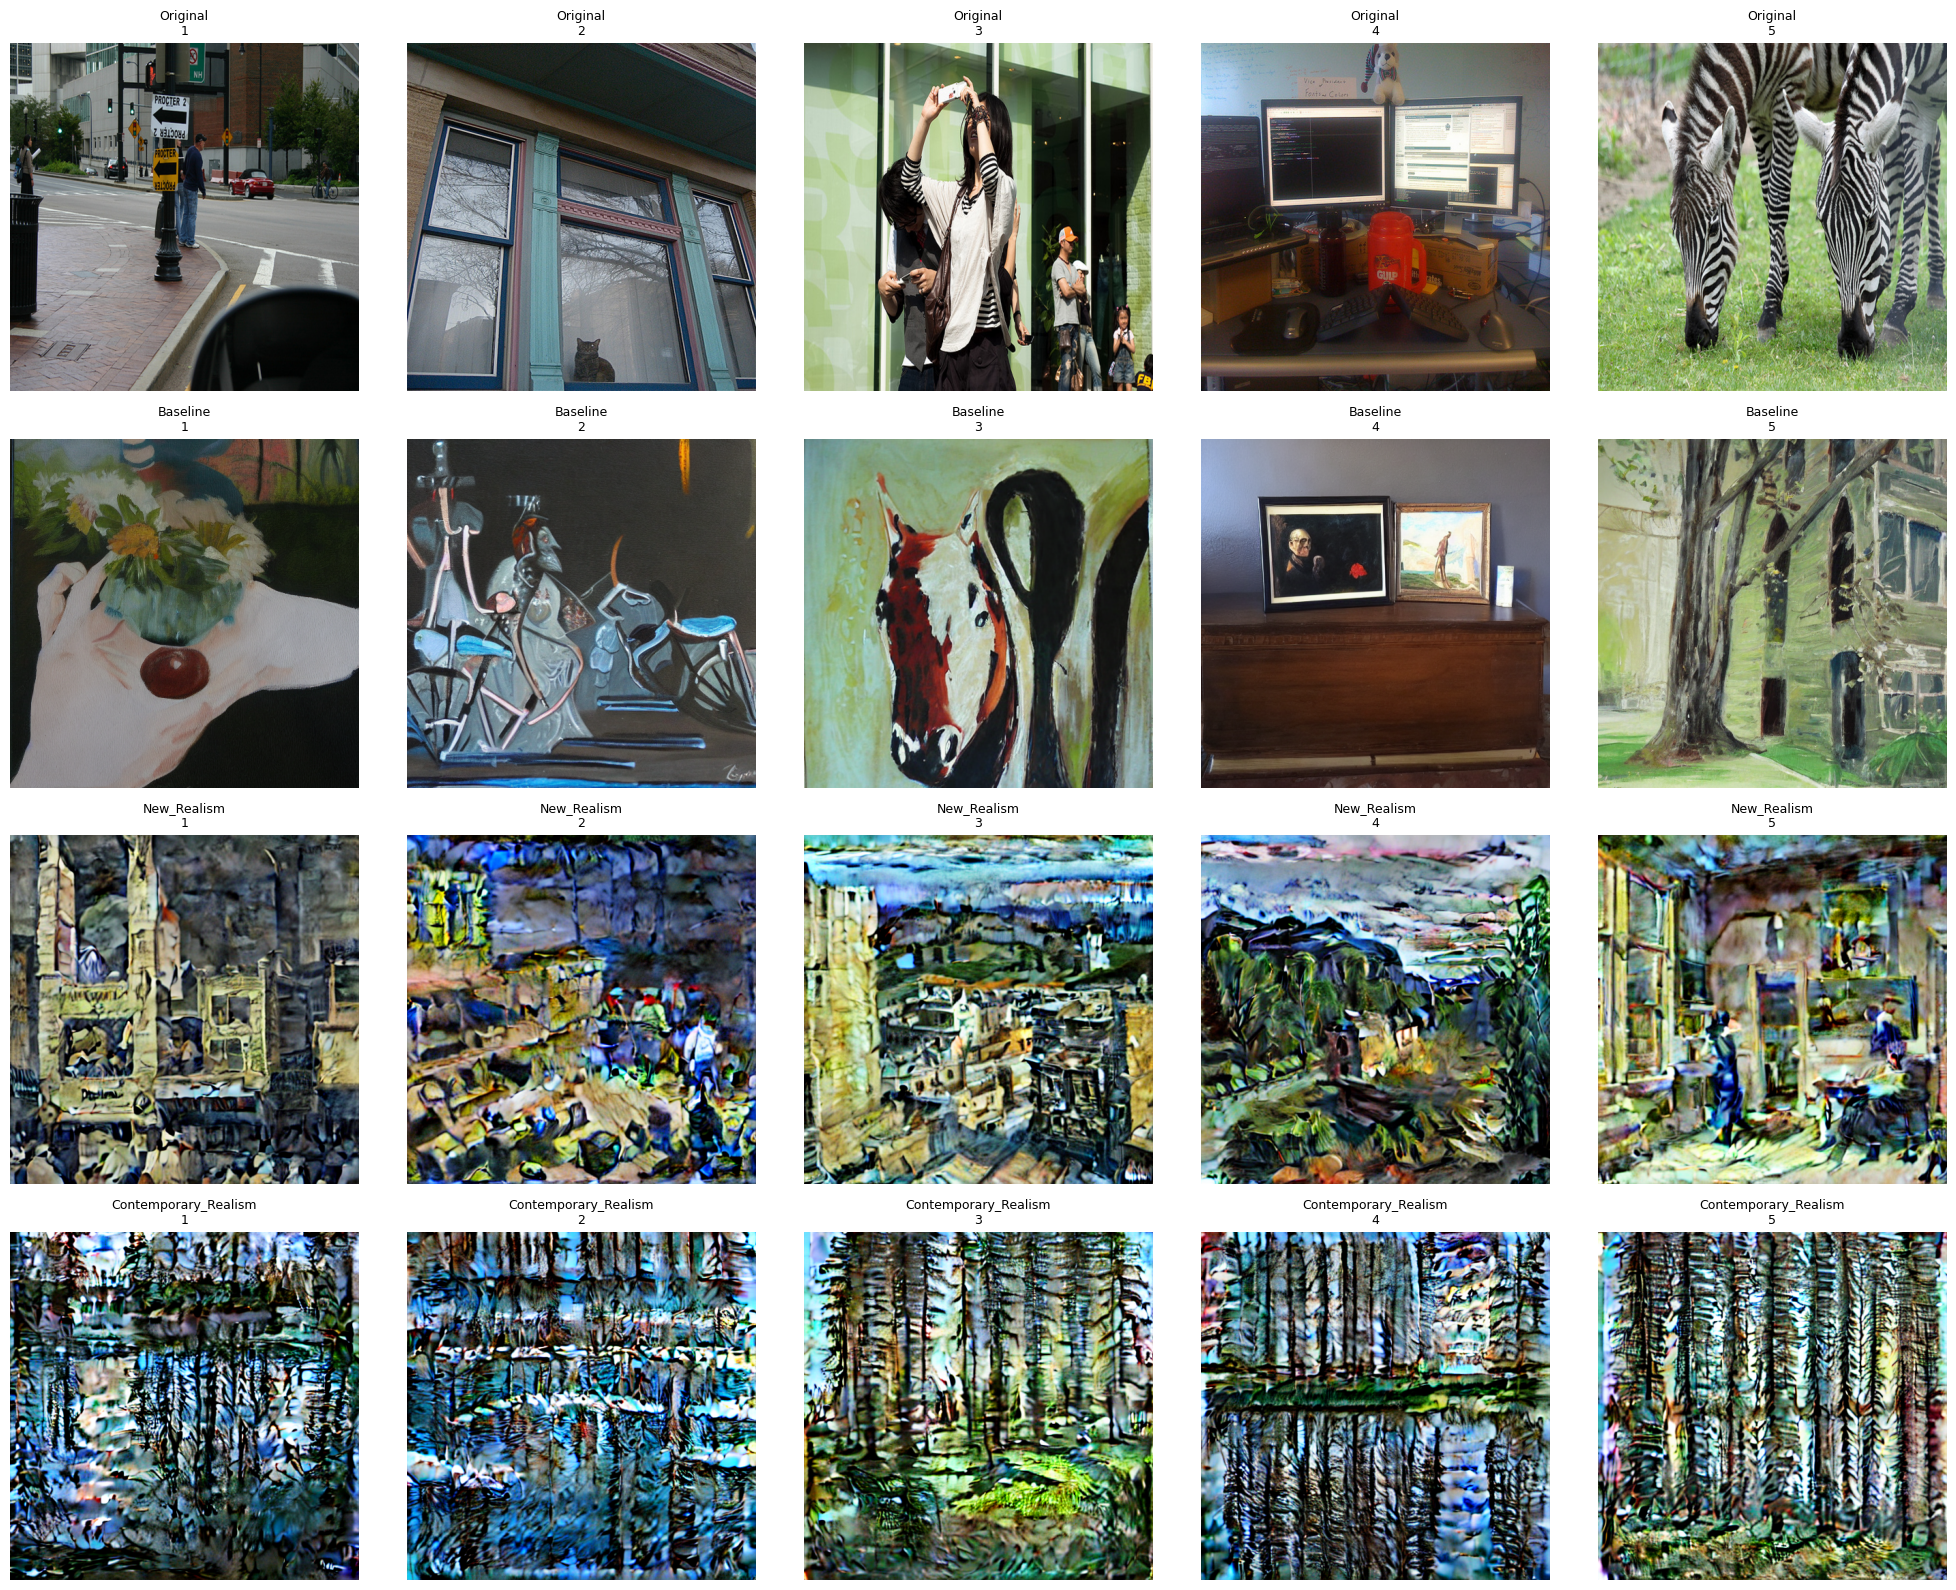

Saved: /kaggle/working/inference_samples/style_transfer_comparison.png


In [8]:
num_images = len(coco_images)
fig, axes = plt.subplots(
    len(STYLES) + 2,
    num_images,
    figsize=(4 * num_images, 4 * (len(STYLES) + 2))
)

for col in range(num_images):
    axes[0, col].imshow(coco_images[col])
    axes[0, col].set_title(f"Original\n{col+1}", fontsize=9)
    axes[0, col].axis('off')
    
    axes[1, col].imshow(baseline_results[col])
    axes[1, col].set_title(f"Baseline\n{col+1}", fontsize=9)
    axes[1, col].axis('off')

for row, style_name in enumerate(STYLES, 2):
    if style_name in all_results:
        for col in range(num_images):
            axes[row, col].imshow(all_results[style_name][col])
            axes[row, col].set_title(f"{style_name}\n{col+1}", fontsize=9)
            axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "style_transfer_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"Saved: {OUTPUT_DIR / 'style_transfer_comparison.png'}")


low_strength: strength=0.5, guidance=7.5


  0%|          | 0/25 [00:00<?, ?it/s]

default: strength=0.75, guidance=7.5


  0%|          | 0/37 [00:00<?, ?it/s]

high_strength: strength=0.9, guidance=7.5


  0%|          | 0/45 [00:00<?, ?it/s]

high_guidance: strength=0.75, guidance=9.0


  0%|          | 0/37 [00:00<?, ?it/s]

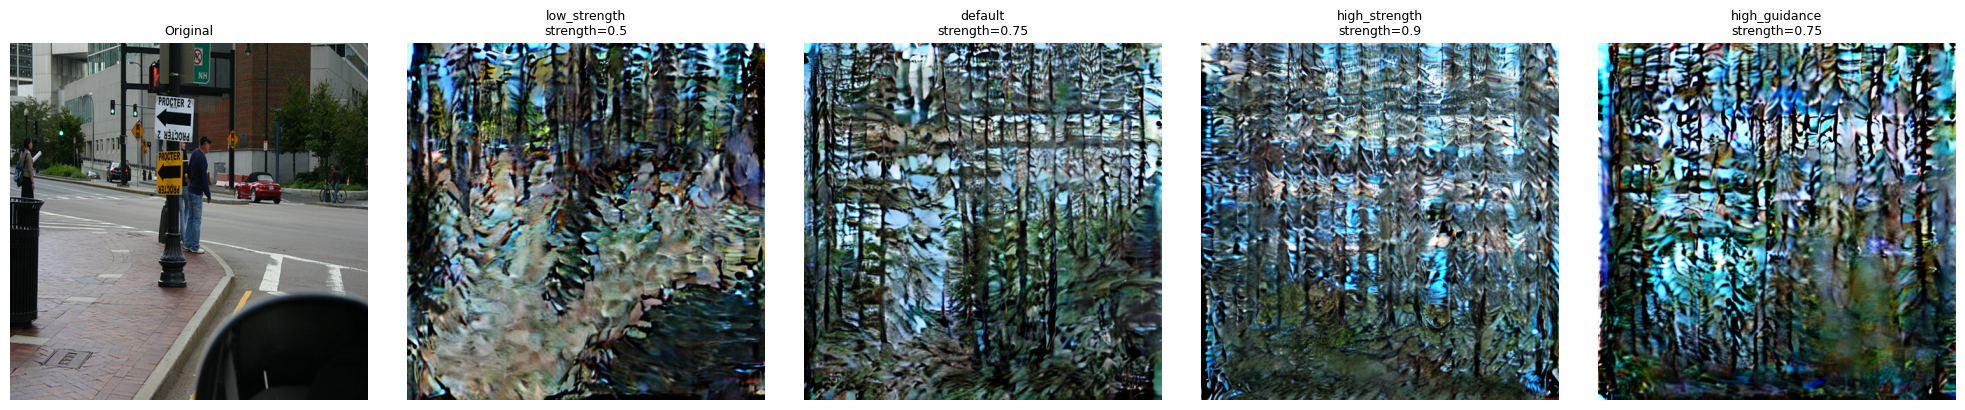

Saved: /kaggle/working/inference_samples/Contemporary_Realism_parameter_comparison.png


In [9]:
test_style = "Contemporary_Realism"
test_image_idx = 0

if test_style in style_pipelines and test_image_idx < len(coco_images):
    pipeline = style_pipelines[test_style]
    test_img = coco_images[test_image_idx]
    
    configs = [
        {"strength": 0.5, "guidance_scale": 7.5, "name": "low_strength"},
        {"strength": 0.75, "guidance_scale": 7.5, "name": "default"},
        {"strength": 0.9, "guidance_scale": 7.5, "name": "high_strength"},
        {"strength": 0.75, "guidance_scale": 9.0, "name": "high_guidance"},
    ]
    
    fig, axes = plt.subplots(1, len(configs) + 1, figsize=(20, 4))
    
    axes[0].imshow(test_img)
    axes[0].set_title("Original", fontsize=9)
    axes[0].axis('off')
    
    for idx, config in enumerate(configs, 1):
        print(f"{config['name']}: strength={config['strength']}, guidance={config['guidance_scale']}")
        result = pipeline(
            prompt=prompt,
            image=test_img,
            strength=config["strength"],
            num_inference_steps=50,
            guidance_scale=config["guidance_scale"],
        ).images[0]
        axes[idx].imshow(result)
        axes[idx].set_title(f"{config['name']}\nstrength={config['strength']}", fontsize=9)
        axes[idx].axis('off')
        result.save(OUTPUT_DIR / f"{test_style}_params_{config['name']}.png")
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f"{test_style}_parameter_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: {OUTPUT_DIR / f'{test_style}_parameter_comparison.png'}")
else:
    print(f"Style {test_style} not loaded or image index invalid")


## Cleanup


In [10]:
for style_name in style_pipelines.keys():
    del style_pipelines[style_name]
del baseline_pipeline

if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("Cleanup completed")


RuntimeError: dictionary changed size during iteration